In [1]:
import paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from database.models import Merge, Story
from database.database import Database
from shared.calculation import query_and_calculate_ownership, average

database = Database(paths.DATABASE_PATH, cached=True)

results = {}

for merge in database.query(Merge.LABEL, where("story_id") != None):
    story = database.query(Story.LABEL, where("id") == merge.story_id)[0]
    sprints = len(story.sprints)
    ownership = query_and_calculate_ownership(database, merge.project_id, merge.timestamp)

    results[datetime.utcfromtimestamp(merge.timestamp)] = {
        "sprints": sprints,
        "ownership": ownership
    }

    results = dict(sorted(results.items()))

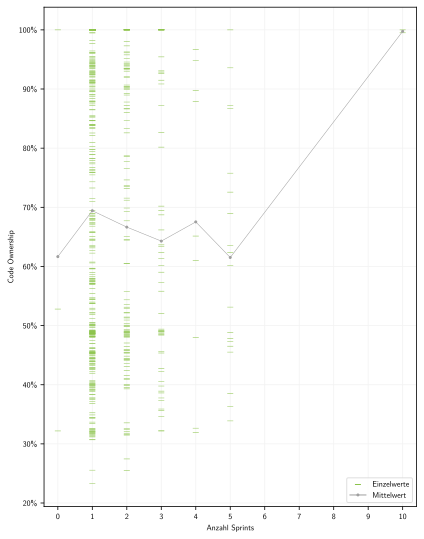

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Einzelwerte
plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, locals.TEXTHEIGHT_SMALL))

sprints = [results[dt]["sprints"] for dt in results.keys()]
ownership = [results[dt]["ownership"] for dt in results.keys()]

ax.scatter(sprints, ownership, color=locals.MATERIAL_COLORS["lightgreen"], marker="_",
    linewidths=0.5, zorder=1, label="Einzelwerte")

# Durchschnitt pro Anzahl an Sprints
ownership_overview = {sprint: [] for sprint in range(max(sprints)+1)}

for result in results.values():
    ownership_overview[result["sprints"]].append(result["ownership"])

averages = {}

for sprint, values in ownership_overview.items():
    if values:
        averages[sprint] = average(values)

ax.plot(list(averages.keys()), list(averages.values()), zorder=2,
    color=locals.MATERIAL_COLORS["gray"], linewidth=0.5, marker=".", markersize=4, label="Mittelwert")

legend = ax.legend(loc="lower right", edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_linewidth(1)

ax.xaxis.set_major_locator(mticker.MultipleLocator(1.0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

ax.margins(x=0.04)
ax.set_xlabel("Anzahl Sprints")
ax.set_ylabel("Code Ownership")
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()